$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$

In [1]:
# 初期化
import matplotlib.pyplot as plt
import numpy as np

# Qiskitをインポート
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

# 基本的な描画ツールをインポート
from qiskit.visualization import plot_histogram

#本テキストで提供されている grover_problem_oracle をインポート
from qiskit_textbook.problems import grover_problem_oracle

## 4. 練習問題: 

### 1.
grover_problem_oracle(4, variant=2) は4量子ビットを使用していて、1つの解を持ちます。

  a. この解を測定する確率が90％を超えるには、何回の反復が必要ですか？

  b. グローバーのアルゴリズムを使用して、この解となる状態を見つけてください。

  c. 上記の問題1aで計算した反復数をさらに増やすとどうなりますか？それはなぜでしょうか？
***

### 1 - a. 
　本章テキストの前半 (https://ibm.box.com/s/haur9aijeltnt7r05mf9atqqirguweob) で見たように、初期状態 $\ket{s}$ に対して oracle + diffuser の操作のセット ($U_s U_{\omega}$) を $t$ 回繰り返すと、操作後の状態は
 
 \begin{equation}
 (U_s U_{\omega})^t \ket{s} = \sin{\theta_t}\ket{\omega} + \cos{\theta_t}\ket{s'} \quad\quad \left(\theta_t = (2t + 1)\theta \quad \rm{and} \quad \theta =\arcsin{\frac{1}{\sqrt{\mathit{N}}}}\right)
 \end{equation}
 
 と表せる。解を測定する確率が90%を超えるには、$\sin^2{\theta_t} > 0.9$ となる $t$ を求めればよい。今は4量子ビット系であるから、$N=2^4$ のもとでこれを解く。

In [2]:
N = 2**4
theta = np.arcsin(1/np.sqrt(N))

def probability(t):
     p = (np.sin((2*t+1)*theta))**2
     return p

print('probability')
for i in range(1,5):
    print(f't = {i} : {probability(i)}')

probability
t = 1 : 0.47265625
t = 2 : 0.908447265625
t = 3 : 0.9613189697265625
t = 4 : 0.5817041397094724


よって、最低2回、最善では3回の反復が必要である。

***
### ※補足
　初期状態 $\ket{s}$ は、 解のみから成る状態 $\ket{\omega}$ と解を含まない状態 $\ket{s'}$
 
 \begin{equation}
 \ket{\omega} = \frac{1}{\sqrt{N}}\sum_{x \in 解}\ket{x}, \quad \ket{s'} = \frac{1}{\sqrt{N-M}}\sum_{x\in解以外}\ket{x}
 \end{equation}
 
 を用いて
 
 \begin{equation}
 \ket{s}=\frac{1}{\sqrt{N}}\left(\sqrt{M}\ket{\omega}+\sqrt{N-M}\ket{s'}\right)  := \sin{\theta}\ket{\omega} + \cos{\theta}\ket{s'}
 \end{equation}
 
 と書ける。テキストや本問は $M=1$ の場合である。
 
 　これに対して oracle + diffuser のセット ($U_s U_{\omega}$) を $t$ 回繰り返すと、操作後の状態として
 
 \begin{equation}
 (U_s U_{\omega})^t \ket{s} = \sin{\theta_t}\ket{\omega} + \cos{\theta_t}\ket{s'} \quad\quad \left(\theta_t = (2t + 1)\theta \quad \rm{and} \quad \theta =\arcsin{\sqrt{\mathit{\frac{M}{N}}}}\right)
 \end{equation}
 
 が得られる。
 
 　最適な反復回数は、これが $\ket{\omega}$に最も近づくとき、つまり $\theta_t$ が $\pi/2$ に最も近くなるときの $t$ であり、
  
 \begin{equation}
 \frac{\pi}{4\theta}-\frac{1}{2}
 \end{equation}
 
 に最も近い整数 $t^*$ であると見積もられる。この整数 $t^*$ の上限は、
 
 \begin{equation}
 \theta \ge \sin{\theta}=\sqrt{\frac{M}{N}}
 \end{equation}
 
 を用いて
 
 \begin{equation}
 t^* \le \left(\frac{\pi}{4\theta}-\frac{1}{2}\right)+1 = \frac{\pi}{4\theta}+\frac{1}{2} \le \frac{\pi}{4}\sqrt{\frac{M}{N}}+\frac{1}{2} 
 \end{equation}
 
と評価できる。このことから、グローバーのアルゴリズムの計算量は $O(\sqrt{M/N})$ であり、古典アルゴリズムの $O(M/N)$ に対して2次の加速を実現していることが分かる。
***

### 1 - b. 
　テキストの例と同様にグローバーのアルゴリズムを実行する。（利用できる関数はそのまま利用する。）

In [3]:
def initialize_s(qc, qubits):
    for q in qubits:
        qc.h(q) #すべてのqubitをH-gateで初期化する
    return qc

def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Hゲートで |s> -> |00..0> に変換
    for qubit in range(nqubits):
        qc.h(qubit)
    # Xゲートで |00..0> -> |11..1> に変換
    for qubit in range(nqubits):
        qc.x(qubit)
    # マルチ制御Zゲートをかけます
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # マルチ制御トフォリ
    qc.h(nqubits-1)
    # |11..1> -> |00..0> に変換
    for qubit in range(nqubits):
        qc.x(qubit)
    # |00..0> -> |s> に変換
    for qubit in range(nqubits):
        qc.h(qubit)
    # Diffuserをゲートにします
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

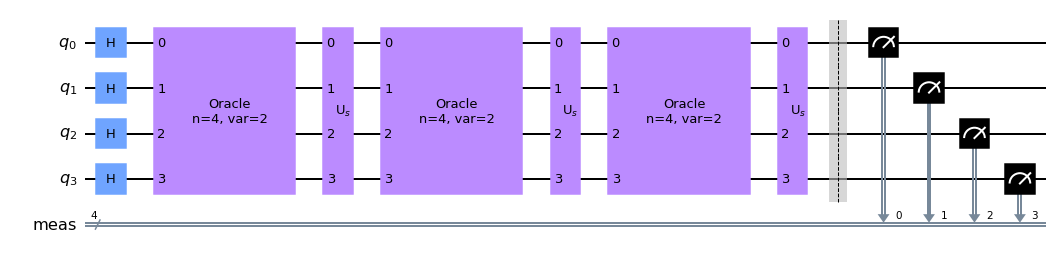

In [4]:
#初期状態を用意
n = 4
oracle = grover_problem_oracle(n, variant=2)
grover_circuit = QuantumCircuit(n)
grover_circuit = initialize_s(grover_circuit, [0,1,2,3])

#最善の反復回数として、oracle + diffuser のセットを3回作用させる
for i in range(3):
    grover_circuit.append(oracle, [0,1,2,3])
    grover_circuit.append(diffuser(n), [0,1,2,3])

grover_circuit.measure_all()
grover_circuit.draw('mpl')

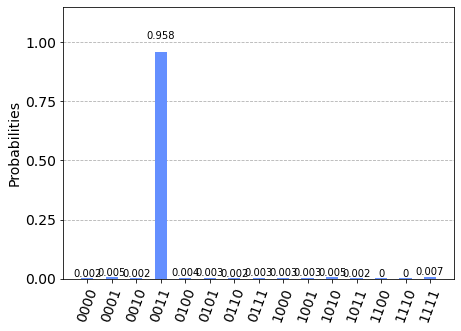

In [5]:
aer_sim = Aer.get_backend('aer_simulator')
transpiled_grover_circuit = transpile(grover_circuit, aer_sim)
qobj = assemble(transpiled_grover_circuit)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)

状態 $\ket{0011}$ が求めるべき1つの解であると推定できる。実際、grover_problem_oracle には n=4, variant=2 のとき以下のように解が設定されている：

In [6]:
grover_problem_oracle(4, variant=2, print_solutions=True)

Solutions:
|0011>


***
### 1 - c.

　問題1-aで見たように、解の観測確率は反復回数を $t$ として $\sin^2{(2t+1)\theta}$ に従う。問題1-aで $t=3$ が最善であると分かったので、4回以上反復すると確率はかえって減少し始める。ただし $\sin^2{(2t+1)\theta}$ は周期関数であるので、長期的にはその後も増加/減少を繰り返すことになる。（しかし現実にはゲートの持つエラーがあるので、反復回数は十分な観測確率が得られるならできるだけ少ない方がよいだろう）

========================================================================================================================

### 2.

2つの解と4つの量子ビットの場合、解を測定する確率が90％を超えるには、何回の反復が必要ですか。 grover_problem_oracle(4, variant=1)を使用して回答をテストしてください（2つの解があります）。
***

grover_problem_oracle(4, variant=1) は以下の2つの解を持つ：

In [7]:
grover_problem_oracle(4, variant=1, print_solutions=True)

Solutions:
|0111>
|1001>


4量子ビット系（$N=2^4$）で2つの解を持つ（$M=2$）とき、最適な反復回数 $t^*$は

In [8]:
N = 2**4
M = 2
theta = np.arcsin(np.sqrt(M/N))

t = np.pi/(4*theta) - 1/2
print(t)

1.6734079041462837


より2回と見積もられ（問題1-a 補足 参照）、実際、観測確率も以下のように $t=2$ で90%を超える。

In [9]:
print('probability')
for i in range(1,5):
    print(f't = {i} : {probability(i)}')

probability
t = 1 : 0.7812500000000001
t = 2 : 0.9453124999999999
t = 3 : 0.330078125
t = 4 : 0.01220703125000009


問題1-bと同様に、grover_problem_oracle(4, variant=1)を用いてグローバーのアルゴリズムを実行する。

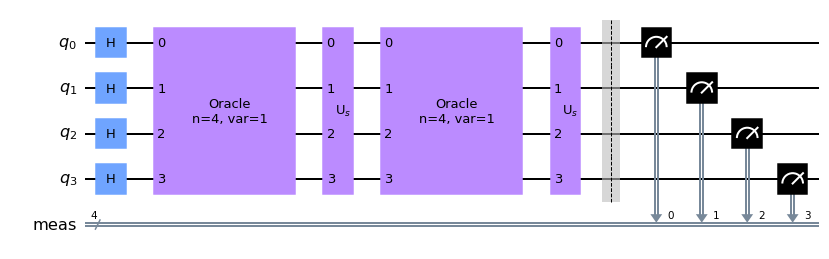

In [10]:
#初期状態を用意
n = 4
oracle = grover_problem_oracle(n, variant=1)
grover_circuit = QuantumCircuit(n)
grover_circuit = initialize_s(grover_circuit, [0,1,2,3])

#最善の反復回数として、oracle + diffuser のセットを2回作用させる
for i in range(2):
    grover_circuit.append(oracle, [0,1,2,3])
    grover_circuit.append(diffuser(n), [0,1,2,3])

grover_circuit.measure_all()
grover_circuit.draw('mpl')

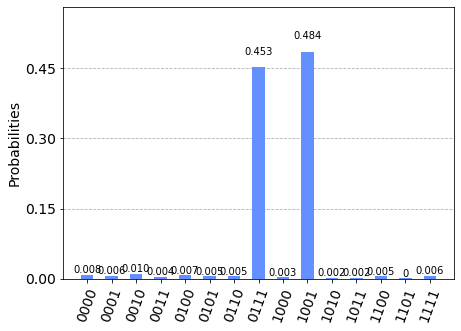

In [11]:
aer_sim = Aer.get_backend('aer_simulator')
transpiled_grover_circuit = transpile(grover_circuit, aer_sim)
qobj = assemble(transpiled_grover_circuit)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)

たしかにgrover_problem_oracle(4, variant=1)に設定されている2解のみが高い確率で得られる。

========================================================================================================================

### 3.

以下を入力とする関数grover_solver(oracle, iterations) を作成してください：

　　ゲートとしてのグローバーオラクル(oracle)  
　　反復の数（整数）(iterations)

その際、'iterations'の反復を使用して、'oracle' ゲートでグローバーのアルゴリズムを実行する QuantumCircuit を返すようにしてください。
***

In [12]:
def grover_solver(oracle, iterations):
    
    def initialize_s(qc, qubits):
        for q in qubits:
            qc.h(q)
        return qc

    def diffuser(nqubits):
        qc = QuantumCircuit(nqubits)
        for qubit in range(nqubits):
            qc.h(qubit)
        for qubit in range(nqubits):
            qc.x(qubit)
        qc.h(nqubits-1)
        qc.mct(list(range(nqubits-1)), nqubits-1)
        qc.h(nqubits-1)
        for qubit in range(nqubits):
            qc.x(qubit)
        for qubit in range(nqubits):
            qc.h(qubit)
        U_s = qc.to_gate()
        U_s.name = "U$_s$"
        return U_s
    
    #初期状態を用意
    n = oracle.num_qubits #oracle が Gate class で入力されることを想定
    grover_circuit = QuantumCircuit(n)
    grover_circuit = initialize_s(grover_circuit, [q for q in range(n)])

    #oracle + diffuser のセットを iterations 回作用させる
    for i in range(iterations):
        grover_circuit.append(oracle, [q for q in range(n)])
        grover_circuit.append(diffuser(n), [q for q in range(n)])

    grover_circuit.measure_all()
    
    return grover_circuit

例として、問題1-bで扱った  
　　oracle = grover_problem_oracle(4, variant=2)  
　　iterations = 3  
とした回路を描いてみる。

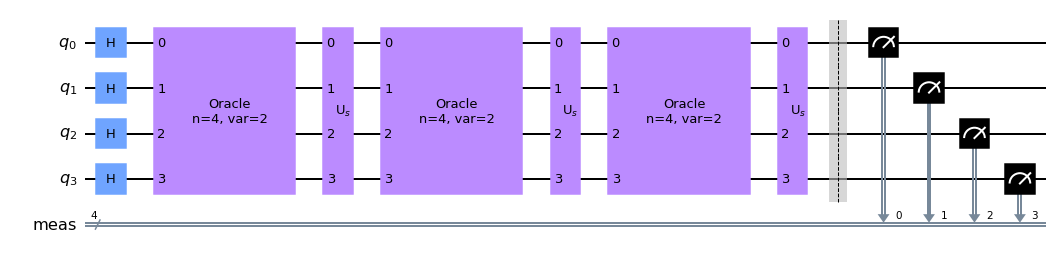

In [13]:
grover_solver(grover_problem_oracle(4, variant=2), 3).draw('mpl')